In [1]:
%load_ext autoreload
%autoreload 2

# checking the new config

In [88]:
from polarbert.config import PolarBertConfig

In [89]:
import yaml
config_file = "/groups/pheno/inar/PolarBERT/configs/polarbert_new.yaml"

try:
    config = PolarBertConfig.from_yaml(config_file)

    # --- Calculate Runtime Params (example, needs actual train_loader length) ---
    # Replace '10000' with len(train_loader) from your script
    # Note: len(dataloader) with IterableDataset might be tricky, often needs manual setting.
    # Let's assume you know the number of batches per epoch for the dataloader.
    num_batches_per_epoch = 10000 # Placeholder! Calculate this properly.
    config.calculate_runtime_params(num_batches_per_epoch)
    print("\n--- Calculated Runtime Params ---")
    print(f"Total Steps: {config.training.total_steps}")
    print(f"Grad Accum Steps: {config.training.gradient_accumulation_steps}")
    print(f"Effective Batch Size: {config.training.effective_batch_size}")
    print(f"Final pct_start for Scheduler: {config.training.pct_start:.4f}")


    print("\n--- Accessing Config ---")
    print(f"Model Name: {config.model.model_name}")
    print(f"Time Embedding Dim: {config.model.embedding.time_embedding_dim}")
    print(f"Optimizer Beta1: {config.training.adam_beta1}")
    print(f"Checkpoint Dir: {config.training.checkpoint.dirpath}")

    # Example saving
    # config.save_yaml('saved_config_copy.yaml')

    # Example loading from checkpoint dir
    # cp_path = 'checkpoints/your_model_run/epoch=01-step=1000.ckpt'
    # config_from_cp = PolarBertConfig.from_checkpoint(cp_path)
    # print(f"\nLoaded config from checkpoint dir. Project: {config_from_cp.training.logging.project}")

except (FileNotFoundError, ValueError, yaml.YAMLError, TypeError) as e:
     print(f"\nError loading/validating/calculating config: {e}")

Loading configuration from: /groups/pheno/inar/PolarBERT/configs/polarbert_new.yaml
Validating configuration...
Configuration validation passed (with potential warnings).
Calculating runtime training parameters...
  Logical Batch Size: 4096
  Max Per Device Batch Size: 4096
  Calculated Per Device Batch Size: 4096
  Gradient Accumulation Steps: 1
  Effective Batch Size: 4096
  Steps per Epoch (logical): 10000
  Total Steps: 200000
  Overriding pct_start based on warm_up_steps: 0.2000 -> 0.0050

--- Calculated Runtime Params ---
Total Steps: 200000
Grad Accum Steps: 1
Effective Batch Size: 4096
Final pct_start for Scheduler: 0.0050

--- Accessing Config ---
Model Name: polarbert_time_embed
Time Embedding Dim: 128
Optimizer Beta1: 0.9
Checkpoint Dir: checkpoints


In [92]:
config.data.train_events = 100_000
config.data.per_device_batch_size = 32

In [93]:
from pprint import pprint
config = PolarBertConfig.from_yaml(config_file)
config_dict = config.to_dict()
pprint(config_dict)

Loading configuration from: /groups/pheno/inar/PolarBERT/configs/polarbert_new.yaml
Validating configuration...
Configuration validation passed (with potential warnings).
{'data': {'max_per_device_batch_size': 4096,
          'num_workers': 1,
          'persistent_workers': True,
          'pin_memory': False,
          'train_dir': '/groups/pheno/inar/icecube_kaggle/memmaped_100M_127',
          'train_events': 100000000,
          'val_dir': '/groups/pheno/inar/icecube_kaggle/memmaped_eval_1M_127',
          'val_events': 200000},
 'model': {'embedding': {'aux_embedding_dim': 4,
                         'charge_bin_max': 0.9,
                         'charge_bin_min': -0.6,
                         'charge_embedding_dim': 16,
                         'charge_vocab_size': 128,
                         'dom_embedding_dim': 108,
                         'dom_vocab_size': 5162,
                         'embedding_dim': 256,
                         'embedding_projection': False,
       

In [6]:
from polarbert.pretraining import get_dataloaders

In [7]:
config = PolarBertConfig.from_yaml(config_file)
config_dict = config.to_dict()
config_dict["training"]["per_device_batch_size"] = 32
train_loader, val_loader = get_dataloaders(config_dict, dataset_type='kaggle')

Loading configuration from: /groups/pheno/inar/PolarBERT/configs/polarbert_new.yaml
Validating configuration...
Configuration validation passed (with potential warnings).


# Exporing charge distribution for optimal quantization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [ ]:
# T_evt[:len(selected_idx), 0] = (time[selected_idx] - 1e4) / 3e4
# T_evt[:len(selected_idx), 1] = np.log10(charge[selected_idx]) / 3.0
# T_evt[:len(selected_idx), 2] = auxiliary[selected_idx] - 0.5 # aux = True is BAD, so 0.5 is bad
# T_evt[:len(selected_idx), 3] = sensor_id[selected_idx] + 1  # +1 is needed since we use 0 for padding

for batch in train_loader:
    break
(x, l), (y, c) = batch

In [19]:
(x, l), (y, c) = batch

# Create padding mask (same as in embedding.py)
batch_size, max_seq_len, _ = x.shape
padding_mask = torch.arange(max_seq_len, device=x.device)[None, :] >= l[:, None]

# Get charge values (feature index 1)
charges = x[:, :, 1]

In [24]:
padding_mask
non_pad_mask = ~padding_mask
charges[non_pad_mask].shape

torch.Size([2136])

Total non-masked charges collected: 204943


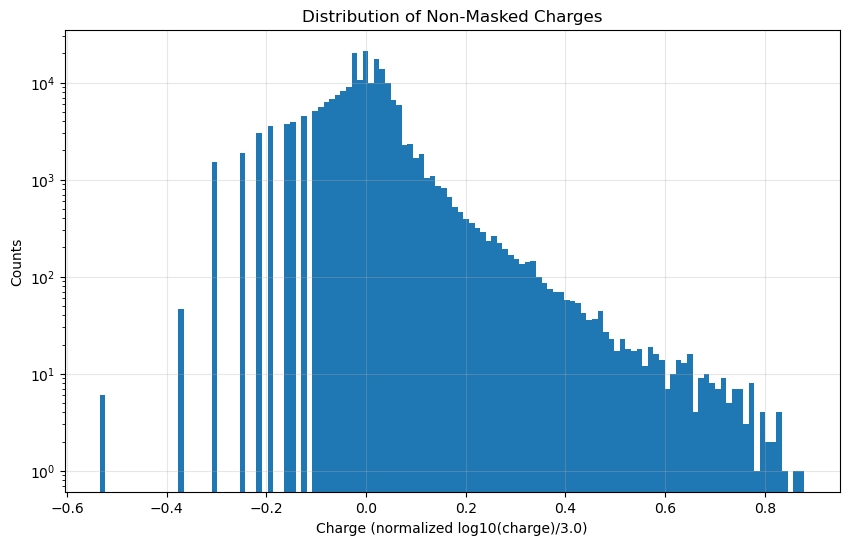

In [50]:
charges_non_masked = []

for i, batch in enumerate(train_loader):
    (x, l), (y, c) = batch
    
    # Create padding mask (same as in embedding.py)
    batch_size, max_seq_len, _ = x.shape
    padding_mask = torch.arange(max_seq_len, device=x.device)[None, :] >= l[:, None]
    
    # Get charge values (feature index 1)
    charges = x[:, :, 1]
    
    # Create mask for non-padded positions
    non_pad_mask = ~padding_mask

    auxiliary_mask = x[:, :, 2] == -0.5  # Non-auxiliary pulses
    combined_mask = non_pad_mask & auxiliary_mask
    
    # Extract only non-padded charges
    valid_charges = charges[combined_mask]
    
    # Append to our collection
    charges_non_masked.append(valid_charges)
    
    if i > 200:
        break

# Concatenate all charges into a single tensor
charges_non_masked = torch.cat(charges_non_masked)
print(f"Total non-masked charges collected: {len(charges_non_masked)}")

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(charges_non_masked.cpu().numpy(), bins=126)
plt.xlabel("Charge (normalized log10(charge)/3.0)")
plt.ylabel("Counts")
plt.yscale("log")
plt.title("Distribution of Non-Masked Charges")
plt.grid(alpha=0.3)

Text(0.5, 0, 'Charge')

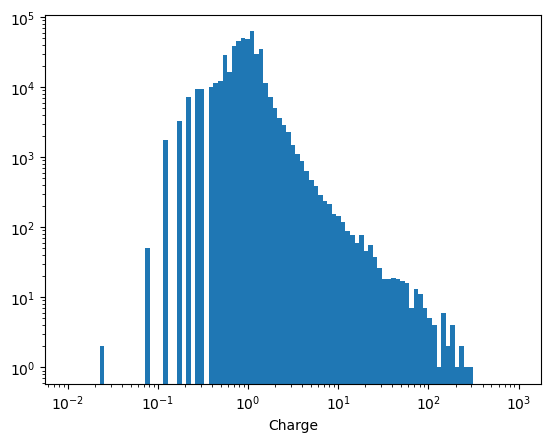

In [44]:
# np.log10(charge[selected_idx]) / 3.0
plt.hist(np.power(10, charges_non_masked.numpy()*3.0), bins=np.logspace(-2,3, 100))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Charge")


128

In [53]:
NUM_CHARGE_BINS = config.model.embedding.charge_vocab_size - 2 # e.g., 128 - 2 = 126
CHARGE_BIN_MIN = -0.5 # Define the range for binning
CHARGE_BIN_MAX = 0.9

In [71]:



for batch in train_loader:
    break
(x, l), (y, c) = batch

batch_size, max_seq_len, _ = x.shape
padding_mask = torch.arange(max_seq_len, device=x.device)[None, :] >= l[:, None]

charge_normalized = x[:, :, 1]
charge_normalized.shape, padding_mask.shape

(torch.Size([32, 127]), torch.Size([32, 127]))

In [ ]:
bin_edges = torch.linspace(
    CHARGE_BIN_MIN,
    CHARGE_BIN_MAX,
    steps=NUM_CHARGE_BINS + 1, # Need N+1 edges for N bins
    device=x.device
)
# Should it be an attribute  of the embedding class, so that we don't construct it per each batch? Or we can have problems with multi deivce training (if we do it at some point)?

In [61]:
# Bucketize the normalized charge values
# Values <= edge[0] get index 0. Values > edge[-1] get index NUM_CHARGE_BINS.
# Values in (edge[i], edge[i+1]] get index i+1.
# Using right=True : (lower, upper] intervals
bucket_indices = torch.bucketize(charge_normalized, bin_edges, right=True)
bucket_indices.shape

torch.Size([32, 127])

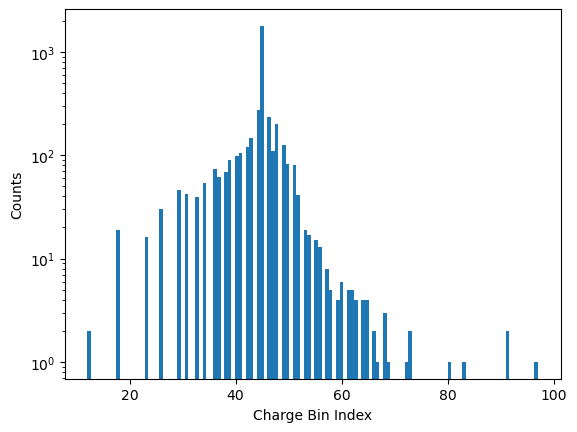

In [77]:
plt.hist(bucket_indices.flatten().numpy(), bins=NUM_CHARGE_BINS-1);
plt.xlabel("Charge Bin Index")
plt.ylabel("Counts")
plt.yscale("log")

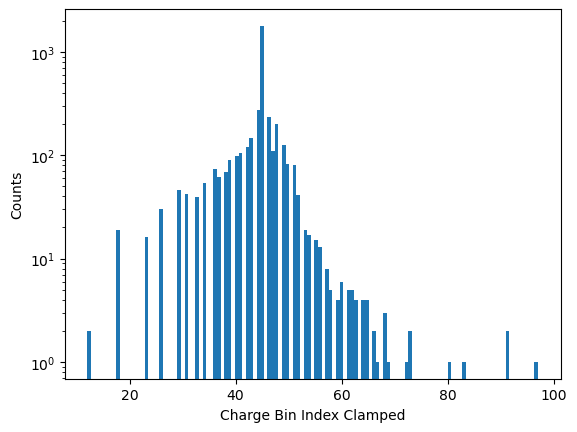

In [78]:
# Map bucket indices (0 to NUM_CHARGE_BINS) to data indices (1 to NUM_CHARGE_BINS)
# Clamp indices: map 0 -> 1, keep 1..NUM_CHARGE_BINS as is.
# Effectively treats underflow/overflow as belonging to the first/last bin.
charge_indices_base = torch.clamp(bucket_indices, min=1, max=NUM_CHARGE_BINS) # Indices are now 1 to 126

plt.hist(charge_indices_base.flatten().numpy(), bins=NUM_CHARGE_BINS-1);
plt.xlabel("Charge Bin Index Clamped")
plt.ylabel("Counts")
plt.yscale("log")

In [74]:
# Apply padding index (PAD_IDX = 0)
PAD_IDX = 0
charge_indices_padded = torch.where(padding_mask, PAD_IDX, charge_indices_base)

# --- (Masking application happens later, after output_mask is calculated) ---
# Placeholder: Assume charge_indices will be masked later if needed
charge_indices = charge_indices_padded # Keep this name consistent for now

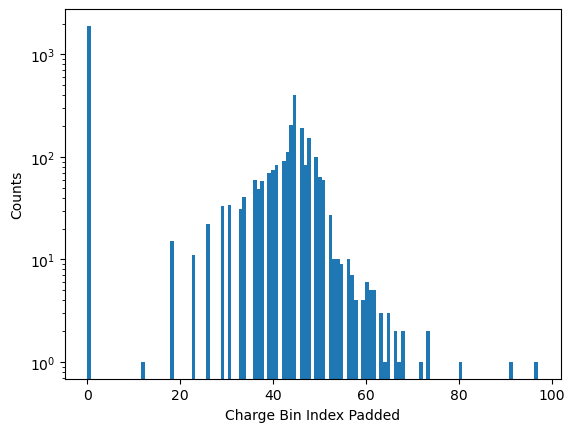

In [79]:
charge_indices
plt.hist(charge_indices.flatten().numpy(), bins=NUM_CHARGE_BINS-1);
plt.xlabel("Charge Bin Index Padded")
plt.ylabel("Counts")
plt.yscale("log")

In [80]:
charge_indices_base

tensor([[41, 46, 49,  ..., 45, 46, 44],
        [34, 41, 47,  ..., 45, 45, 45],
        [46, 37, 39,  ..., 46, 34, 48],
        ...,
        [50, 49, 46,  ..., 47, 45, 38],
        [44, 39, 62,  ..., 40, 46, 46],
        [51, 58, 45,  ..., 45, 45, 45]])

In [81]:
charge_indices

tensor([[41, 46, 49,  ..., 45, 46, 44],
        [34, 41, 47,  ...,  0,  0,  0],
        [46, 37, 39,  ...,  0,  0,  0],
        ...,
        [50, 49, 46,  ...,  0,  0,  0],
        [44, 39, 62,  ...,  0,  0,  0],
        [51, 58, 45,  ...,  0,  0,  0]])

# Putting together the embedding layer

In [94]:
import torch
import torch.nn as nn
import numpy as np # Only needed for float('inf') if torch.inf unavailable in older torch
import warnings
from typing import Tuple, Optional # Added Optional for return type hint

# --- Define Constants calculated FROM Config ---
PAD_IDX = 0

class EnhancedIceCubeEmbedding(nn.Module):
    """
    Embedding layer using index replacement for masking specific features.
    Indices: 0=[PAD], LAST_IDX=[MASK]. Assumes sub-embedding dims sum
    to the final model embedding dimension (no projection layer).
    Quantizes charge based on normalized log values using pre-calculated buffers.
    """
    def __init__(self, config, masking=False):
        """
        Initializes the embedding layer.

        Args:
            config (PolarBertConfig): The main configuration object.
            masking (bool): Whether to enable masking during training.
        """
        super().__init__()
        self.config = config
        self.masking = masking
        embedding_cfg = config.model.embedding

        self.mask_prob = embedding_cfg.masking_prob if masking else 0.0

        # --- Calculate Vocab Sizes and MASK Indices ---
        self.dom_vocab_size = embedding_cfg.dom_vocab_size
        self.dom_mask_idx = self.dom_vocab_size - 1

        self.time_vocab_size = embedding_cfg.time_vocab_size
        self.time_mask_idx = self.time_vocab_size - 1
        self.max_time_duration = self.time_mask_idx - 1

        self.charge_vocab_size = embedding_cfg.charge_vocab_size
        self.charge_mask_idx = self.charge_vocab_size - 1
        self.num_charge_bins = self.charge_vocab_size - 2
        if self.num_charge_bins <= 0:
            raise ValueError("charge_vocab_size must be >= 2 for PAD and MASK indices.")

        # --- TODO: Define Aux Vocab Size and MASK index ---
        self.aux_num_cats = 2 # Example
        self.aux_vocab_size = self.aux_num_cats + 2
        self.aux_mask_idx = self.aux_vocab_size - 1

        # --- Embedding Layers (All use padding_idx=0) ---
        self.dom_embedding = nn.Embedding(
            self.dom_vocab_size, embedding_cfg.dom_embedding_dim, padding_idx=PAD_IDX
        )
        self.time_embedding = nn.Embedding(
            self.time_vocab_size, embedding_cfg.time_embedding_dim, padding_idx=PAD_IDX
        )
        self.charge_embedding = nn.Embedding(
             self.charge_vocab_size, embedding_cfg.charge_embedding_dim, padding_idx=PAD_IDX
        )
        self.aux_embedding = nn.Embedding( # Assuming aux embedding needed
             self.aux_vocab_size, embedding_cfg.aux_embedding_dim, padding_idx=PAD_IDX
        )

        # --- Define and Register Charge Bin Edges Buffer ---
        # Get binning range from config (assuming they are added)
        charge_bin_min = embedding_cfg.charge_bin_min # e.g., -0.6
        charge_bin_max = embedding_cfg.charge_bin_max # e.g., 0.9
        # Create tensor on CPU initially
        charge_bin_edges_tensor = torch.linspace(
            charge_bin_min,
            charge_bin_max,
            steps=self.num_charge_bins + 1 # N+1 edges for N bins
        )
        # Register as buffer - will be moved to device with the module
        self.register_buffer('charge_bin_edges', charge_bin_edges_tensor)


        # --- Optional Projection Layer ---
        self.embedding_dim = config.model.embedding_dim
        total_sub_embed_dim = (
            embedding_cfg.dom_embedding_dim + embedding_cfg.time_embedding_dim +
            embedding_cfg.charge_embedding_dim + embedding_cfg.aux_embedding_dim
        )
        if embedding_cfg.embedding_projection:
             print("INFO: Using projection layer after concatenating embeddings.")
             self.projection = nn.Linear(total_sub_embed_dim, self.embedding_dim)
             if total_sub_embed_dim != self.embedding_dim:
                 print(f"  Projecting from {total_sub_embed_dim} to {self.embedding_dim}")
        elif total_sub_embed_dim == self.embedding_dim:
             print("INFO: Concatenated embeddings directly match model embedding dim. No projection layer used.")
             self.projection = None
        else:
             # Sum doesn't match and projection is False
             raise ValueError(
                 f"[Config Error] embedding_projection is False, but sum of sub-embedding dims ({total_sub_embed_dim}) "
                 f"does not match model.embedding_dim ({self.embedding_dim}). "
                 f"Adjust dimensions or set embedding_projection to True."
             )

        # --- CLS Token ---
        self.cls_embedding = nn.Parameter(torch.randn(1, 1, self.embedding_dim))


    def forward(self, input_batch: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor, Optional[torch.Tensor]]:
        """ Forward pass for the embedding layer. """
        x, l = input_batch
        batch_size, seq_len, _ = x.shape
        device = x.device
        embedding_cfg = self.config.model.embedding

        # --- 1. Get Original Padding Mask ---
        padding_mask = (x[:, :, 3] == PAD_IDX)

        # --- 2. Process Time Feature to Indices ---
        time_normalized = x[:, :, 0]
        time_float_approx = time_normalized * 3e4 + 1e4
        time_float_masked_for_min = torch.where(padding_mask, torch.full_like(time_float_approx, float('inf')), time_float_approx)
        t_min_per_event = torch.min(time_float_masked_for_min, dim=1, keepdim=True)[0]
        t_min_per_event = torch.where(torch.isinf(t_min_per_event), torch.zeros_like(t_min_per_event), t_min_per_event)
        time_relative_float = time_float_approx - t_min_per_event
        time_relative_int = torch.round(time_relative_float).long()
        time_relative_int_clipped = torch.clamp(time_relative_int, min=0, max=self.max_time_duration)
        time_indices = torch.where(padding_mask, PAD_IDX, time_relative_int_clipped + 1)

        # --- 3. Process DOM ID Feature to Indices ---
        dom_indices = x[:, :, 3].long()

        # --- 4. Process Charge Feature to Indices ---
        charge_normalized = x[:, :, 1]
        # Use the buffer for bin edges - it's already on the correct device
        # Note: self.charge_bin_edges is automatically moved by PyTorch's .to(device)
        bucket_indices = torch.bucketize(charge_normalized, self.charge_bin_edges, right=True)
        charge_indices_base = torch.clamp(bucket_indices, min=1, max=self.num_charge_bins)
        charge_indices = torch.where(padding_mask, PAD_IDX, charge_indices_base)

        # --- 5. Process Auxiliary Feature to Indices ---
        aux_normalized = x[:, :, 2]
        aux_base_idx = torch.round(aux_normalized + 0.5).long()
        aux_base_idx_clipped = torch.clamp(aux_base_idx, 0, self.aux_num_cats - 1)
        aux_indices = torch.where(padding_mask, PAD_IDX, aux_base_idx_clipped + 1)

        # --- 6. Apply Masking (Index Replacement) ---
        output_mask = None
        if self.masking:
            is_non_auxiliary = (x[:, :, 2] == -0.5)
            random_mask = torch.rand(is_non_auxiliary.shape, device=device) < self.mask_prob
            output_mask = is_non_auxiliary & random_mask & ~padding_mask

            if embedding_cfg.masking_doms:
                dom_indices = torch.where(output_mask, self.dom_mask_idx, dom_indices)
            if embedding_cfg.masking_times:
                time_indices = torch.where(output_mask, self.time_mask_idx, time_indices)
            if embedding_cfg.masking_charges:
                charge_indices = torch.where(output_mask, self.charge_mask_idx, charge_indices)
            # if embedding_cfg.masking_aux: aux_indices = torch.where(output_mask, self.aux_mask_idx, aux_indices)

        # --- 7. Embedding Lookups ---
        dom_embeds = self.dom_embedding(dom_indices)
        time_embeds = self.time_embedding(time_indices)
        charge_embeds = self.charge_embedding(charge_indices)
        aux_embeds = self.aux_embedding(aux_indices)

        # --- 8. Combine Embeddings ---
        combined_embeds = torch.cat([dom_embeds, time_embeds, charge_embeds, aux_embeds], dim=2)

        # --- 8b. Apply Optional Projection Layer ---
        if self.projection is not None:
            projected_embeds = self.projection(combined_embeds)
        else:
            projected_embeds = combined_embeds

        # --- 9. Prepend CLS Token ---
        cls_token_expanded = self.cls_embedding.expand(batch_size, -1, -1).to(projected_embeds.dtype)
        full_embedding = torch.cat([cls_token_expanded, projected_embeds], dim=1)

        # --- 10. Create Final Padding Mask ---
        final_padding_mask = torch.cat([
             torch.zeros(batch_size, 1, dtype=torch.bool, device=device),
             padding_mask
        ], dim=1)

        # --- 11. Return ---
        return full_embedding, final_padding_mask, output_mask

In [113]:
from polarbert.pretraining import get_dataloaders
from polarbert.time_embedding import IceCubeTimeEmbedding

config_file = "/groups/pheno/inar/PolarBERT/configs/polarbert_new.yaml"
config = PolarBertConfig.from_yaml(config_file)

config = PolarBertConfig.from_yaml(config_file)
config_dict = config.to_dict()
config_dict["training"]["per_device_batch_size"] = 32
train_loader, val_loader = get_dataloaders(config_dict, dataset_type='kaggle')

for batch in train_loader:
    break
(x, l), (y, c) = batch

embedding = IceCubeTimeEmbedding(config, masking=True)

full_embedding, padding_mask, mask = embedding.forward((x,l))

Loading configuration from: /groups/pheno/inar/PolarBERT/configs/polarbert_new.yaml
Validating configuration...
Configuration validation passed (with potential warnings).
Loading configuration from: /groups/pheno/inar/PolarBERT/configs/polarbert_new.yaml
Validating configuration...
Configuration validation passed (with potential warnings).
INFO: Concatenated embeddings directly match model embedding dim. No projection layer used.


In [114]:
# --- Check Shapes ---
B, L_plus_1, E = full_embedding.shape
B_pad, L_plus_1_pad = padding_mask.shape
B_mask, L_mask = mask.shape if mask is not None else (None, None)

print(f"Input Batch Size (B): {batch_size}, Original Seq Len (L_orig): {max_seq_len}")
print(f"Output Embedding Shape (B, L_orig+1, E): {full_embedding.shape}")
print(f"Output Padding Mask Shape (B, L_orig+1): {padding_mask.shape}")
if mask is not None:
    print(f"Output Mask Shape (B, L_orig): {mask.shape}")
else:
    print("Masking disabled, output mask is None.")

# Expected shapes
expected_L_plus_1 = max_seq_len + 1
expected_E = config.model.embedding_dim # Or embedding.embedding_dim
assert L_plus_1 == expected_L_plus_1, f"Expected sequence length {expected_L_plus_1}, got {L_plus_1}"
assert E == expected_E, f"Expected embedding dim {expected_E}, got {E}"
assert L_plus_1_pad == expected_L_plus_1, "Padding mask seq length mismatch"
if mask is not None:
    assert L_mask == max_seq_len, f"Output mask should have original seq len {max_seq_len}, got {L_mask}"

print("\nShape checks passed!")

Input Batch Size (B): 32, Original Seq Len (L_orig): 127
Output Embedding Shape (B, L_orig+1, E): torch.Size([32, 128, 256])
Output Padding Mask Shape (B, L_orig+1): torch.Size([32, 128])
Output Mask Shape (B, L_orig): torch.Size([32, 127])

Shape checks passed!


In [115]:
# --- Check Padding Mask ---
input_padding = (x[:, :, 3] == PAD_IDX) # Assuming PAD_IDX = 0 for DOM input

# Check CLS token padding (should always be False)
assert not torch.any(padding_mask[:, 0]), "CLS token position should not be padded"
print("CLS token padding check passed.")

# Check sequence padding matches input
# Compare padding_mask[:, 1:] with input_padding
# Need to handle potential length mismatch if l causes padding_mask to be shorter
len_diff = padding_mask.shape[1] - 1 - input_padding.shape[1]
if len_diff < 0: # Should not happen if max_seq_len is correct
     print("Warning: padding_mask shorter than input_padding")
     seq_len_to_compare = padding_mask.shape[1] - 1
else:
     seq_len_to_compare = input_padding.shape[1]

match = torch.all(padding_mask[:, 1:1+seq_len_to_compare] == input_padding[:, :seq_len_to_compare])
assert match, "Padding mask for sequence doesn't match input padding"
print("Sequence padding check passed.")

# Visually inspect a sample
print("\nExample Input Padding (0=PAD):")
print(x[0, :, 3].long())
print("\nExample Final Padding Mask (True=PAD):")
print(padding_mask[0])

CLS token padding check passed.
Sequence padding check passed.

Example Input Padding (0=PAD):
tensor([1307, 2462, 4580, 2696, 4168, 1343, 4512, 2452,  163,  163, 1608, 3944,
        3572, 3954,  530, 1303,  277,  967, 4512, 3284, 3284, 3280, 2800, 3720,
        3824, 3286, 3280, 3930, 3280, 1280, 1495, 4528, 3284, 3820, 3762, 1495,
        1495, 3292, 2752, 3822, 3284, 1497, 4248, 4900, 1959, 4968, 3236, 4716,
        5060, 4240, 3954, 3596, 2832, 1688, 4172, 2984,  769, 2772, 3954, 4528,
        4512,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0])

Example Final Padding Mask (True=PAD):
tensor([False,

In [116]:
# --- Check Output Mask ---
if mask is not None:
    print("\n--- Masking Checks ---")
    # 1. Mask should only be True where input wasn't padded
    input_padding_orig = (x[:, :, 3] == PAD_IDX) # Recalculate just in case
    assert not torch.any(mask & input_padding_orig), "Mask should not be True in padded positions"
    print("Masking vs Padding check passed.")

    # 2. Mask should only be True for non-auxiliary pulses
    # Original aux feature: x[:, :, 2] == -0.5 for non-aux, 0.5 for aux
    is_auxiliary = (x[:, :, 2] > 0) # Check where original aux was True (0.5)
    assert not torch.any(mask & is_auxiliary), "Mask should not be True for auxiliary pulses"
    print("Masking vs Auxiliary check passed.")

    # 3. Check masking probability (approximate)
    non_pad_non_aux_mask = (~input_padding_orig) & (~is_auxiliary)
    num_eligible = non_pad_non_aux_mask.sum().item()
    num_masked = mask.sum().item()
    actual_prob = num_masked / num_eligible if num_eligible > 0 else 0
    target_prob = config.model.embedding.masking_prob # Or embedding.mask_prob

    print(f"Number of eligible tokens for masking: {num_eligible}")
    print(f"Number of tokens actually masked: {num_masked}")
    print(f"Actual masking probability: {actual_prob:.4f} (Target: {target_prob})")
    # Check if it's reasonably close (allow some variance due to randomness)
    if num_eligible > 100: # Only check if enough samples
        assert abs(actual_prob - target_prob) < 0.1, "Actual masking prob seems too far from target" # Adjust tolerance
        print("Masking probability check passed (approx).")
    else:
        print("Skipping probability check (too few eligible tokens).")

else:
    print("\nMasking not enabled, skipping mask checks.")


--- Masking Checks ---
Masking vs Padding check passed.
Masking vs Auxiliary check passed.
Number of eligible tokens for masking: 686
Number of tokens actually masked: 169
Actual masking probability: 0.2464 (Target: 0.25)
Masking probability check passed (approx).


In [117]:
# --- Check Embedding Values ---
print("\n--- Embedding Value Checks ---")

# Check embedding for PAD index in time/dom (should ideally be zeros or non-updated)
# Note: requires accessing internal indices calculated in forward, which we didn't return.
# This check is easier within a formal test or by modifying forward to return indices.
# For now, let's check the output embedding where padding_mask is True

padded_embed_indices = padding_mask[:, 1:].nonzero(as_tuple=False) # Get indices where padding is True
if padded_embed_indices.shape[0] > 0:
    sample_pad_idx = padded_embed_indices[0] # Get coords of first padded element
    # Get embedding vector for the first padded position (after CLS)
    padded_vector = full_embedding[sample_pad_idx[0], sample_pad_idx[1] + 1, :]
    print(f"Sample embedding vector at a padded position: {padded_vector[:10]}...") # Print first few dims
    # Often padding idx vector is zeros. Check if sum is close to zero.
    # Note: Can have non-zero gradients if not explicitly excluded in rare optimizer cases, but usually zero.
    if torch.allclose(padded_vector, torch.zeros_like(padded_vector), atol=1e-6):
         print("Padded embedding vector is close to zero (as expected for padding_idx=0).")
    else:
         print("Padded embedding vector is non-zero (might be ok if padding_idx is learned/not 0).")


# Check embedding for MASK index (if using index replacement & masking enabled)
# This also requires accessing the final indices passed to nn.Embedding.
# If using the single mask_token_embed approach (recommended):
if mask is not None and hasattr(embedding, 'mask_token_embed'):
     masked_indices = mask.nonzero(as_tuple=False)
     if masked_indices.shape[0] > 0:
          sample_mask_idx = masked_indices[0]
          # Get embedding vector for the first masked position (after CLS)
          masked_vector = full_embedding[sample_mask_idx[0], sample_mask_idx[1] + 1, :]
          mask_token_param = embedding.mask_token_embed.squeeze()
          print(f"Sample embedding vector at a masked position: {masked_vector[:10]}...")
          print(f"Learned mask_token_embed: {mask_token_param[:10]}...")
          if torch.allclose(masked_vector, mask_token_param, atol=1e-6):
               print("Masked embedding vector matches mask_token_embed parameter.")
          else:
               print("WARNING: Masked embedding vector does NOT match mask_token_embed parameter!")


--- Embedding Value Checks ---
Sample embedding vector at a padded position: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SliceBackward0>)...
Padded embedding vector is close to zero (as expected for padding_idx=0).


In [119]:
# --- Check Device ---
print(f"\nInput tensor device: {x.device}")
print(f"Embedding layer device: {next(embedding.parameters()).device}")
print(f"Output embedding device: {full_embedding.device}")
assert x.device == next(embedding.parameters()).device == full_embedding.device, "Device mismatch!"
print("Device consistency check passed.")


Input tensor device: cpu
Embedding layer device: cpu
Output embedding device: cpu
Device consistency check passed.


In [ ]:
#TODO convret those checks to pytest tests!